In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD

class GP(nn.Module):
    def __init__(self, length_scale = 1.0, noise_scale = 1.0, amplitude_scale = 1.0):
        super().__init__()
        self.length_scale = nn.Parameter(torch.tensor(length_scale))
        self.noise_scale = nn.Parameter(torch.tensor(noise_scale))
        self.amplitude_scale = nn.Parameter(torch.tensor(amplitude_scale))

    def fit(self, X, y):
        D = X.shape[1]
        K = self.kernel_mat(X, X) + (self.noise_scale**2) * torch.eye(len(X))
        K_inv = torch.inverse(K)
        nll = 0.5*y.T.mm(K_inv).mm(y) + torch.log(torch.det(K)) + D*0.5*np.log(2*np.pi)
        self.X = X
        self.y = y
        self.K = K
        return nll
    
    def prediction(self, x):
        y = self.y
        k = self.kernel_mat(self.X, x)
        K_inv = torch.inverse(self.K)
        mu = k.T.mm(K_inv).mm(y)
        var = self.amplitude_scale**2 + self.noise_scale**2 - torch.diag(k.T.mm(K_inv).mm(k))
        var = torch.max(torch.tensor([0]), var) # to avoid numerical issues that might lead to negative variance
        return mu, var
    
    def kernel_mat(self, X, Z):
        Xsq = (X**2).sum(dim=1, keepdim = True)
        Zsq = (Z**2).sum(dim=1, keepdim = True)
        sqdist = Xsq + Zsq.T - 2*X.mm(Z.T)
        return (self.amplitude_scale**2) * torch.exp(-0.5*sqdist/(self.length_scale**2))
    
    def grad_descent_iteration(self, X, y, optimizer):
        optimizer.zero_grad()
        nll = self.fit(X,y)
        nll.backward()
        optimizer.step()
        return {
            "loss": nll.item(),
            "length": self.length_scale.detach().cpu().clone(),
            "noise": self.noise_scale.detach().cpu().clone(),
            "amplitude": self.amplitude_scale.detach().cpu().clone(),
        }

In [2]:
torch.manual_seed(123)
X = torch.tensor([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0]).reshape(-1,1)
f = torch.sin(X).flatten()
y = f + torch.randn_like(f) * 0.1
y = y[:, None]
grid = torch.linspace(-5, 5, 200)[:,None]

Text(0.5, 1.0, 'before parameter optimization')

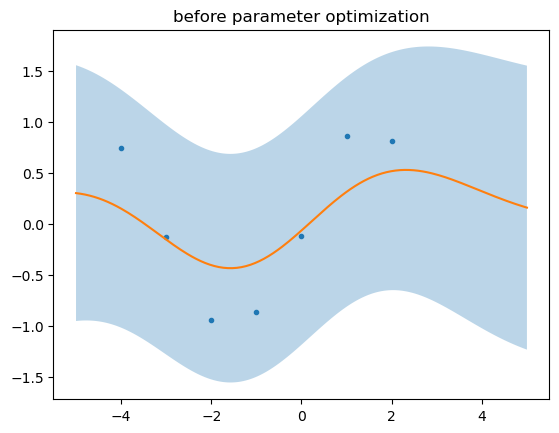

In [3]:
gp = GP(length_scale = 2e0, noise_scale = 1e0, amplitude_scale = 1e0)
gp.fit(X,y)
mu, var = gp.prediction(grid)
mu = mu.detach().numpy().flatten()
std = torch.sqrt(var).detach().numpy().flatten()
plt.plot(X.flatten(), y, '.')
plt.plot(grid.flatten(), mu)
plt.fill_between(grid.flatten(), y1=mu+std, y2=mu-std, alpha=0.3)
plt.title("before parameter optimization")

Text(0.5, 0, 'iteration')

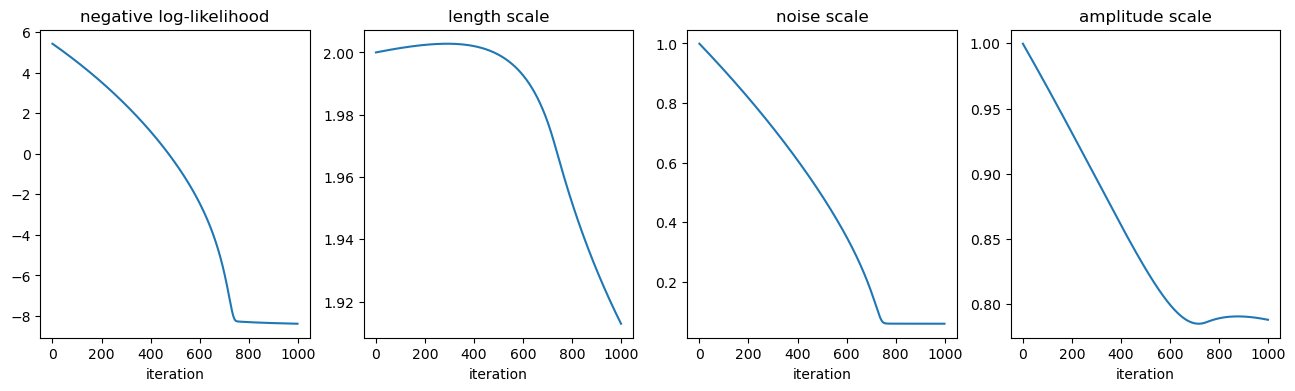

In [4]:
optimizer = SGD(gp.parameters(), lr=1e-4)

l_loss = []
l_length = []
l_noise = []
l_amp = []
for i in range(1000):
    d_train = gp.grad_descent_iteration(X, y, optimizer)
    l_loss.append(d_train['loss'])
    l_length.append(d_train['length'])
    l_noise.append(d_train['noise'])
    l_amp.append(d_train['amplitude'])
    
fig, axs = plt.subplots(ncols=4, figsize=(16,4))
axs[0].plot(l_loss); axs[0].set_title('negative log-likelihood'); axs[0].set_xlabel('iteration')
axs[1].plot(l_length); axs[1].set_title('length scale'); axs[1].set_xlabel('iteration')
axs[2].plot(l_noise); axs[2].set_title('noise scale'); axs[2].set_xlabel('iteration')
axs[3].plot(l_amp); axs[3].set_title('amplitude scale'); axs[3].set_xlabel('iteration')

Text(0.5, 1.0, 'after hyperparameter optimization')

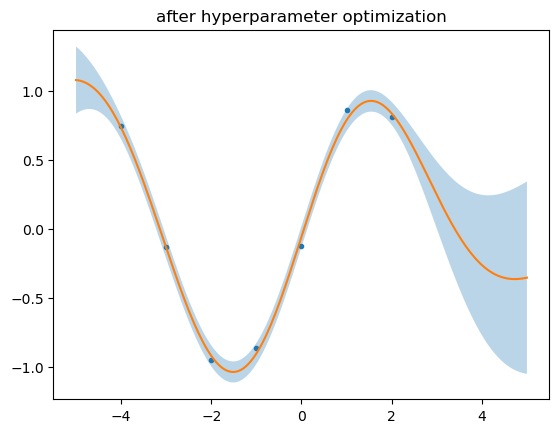

In [5]:
mu, var = gp.prediction(grid)
mu = mu.detach().numpy().flatten()
std = torch.sqrt(var).detach().numpy().flatten()
plt.plot(X.flatten(), y, '.')
plt.plot(grid.flatten(), mu)
plt.fill_between(grid.flatten(), y1=mu+std, y2=mu-std, alpha=0.3)
plt.title('after hyperparameter optimization')